# Sentiment Analysis in Python

1. Sentiment analysis in python using three different techniques:
- VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of words approach
- Roberta Pretrained Model from 🤗 
- Huggingface Pipeline

2. Data Exploration
3. Querying Structured Data using NLTK

# Declaring Modules

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
torch.__version__

plt.style.use('ggplot')

import nltk
pd.plotting.register_matplotlib_converters()

import wordcloud
import re # Regular Expressions
import string         



# Read in data

In [2]:
df = pd.read_csv('customer reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Dealing With Null Values

In [4]:
df.isna()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
495,False,False,False,False,False,False,False,False,False,False
496,False,False,False,False,False,False,False,False,False,False
497,False,False,False,False,False,False,False,False,False,False
498,False,False,False,False,False,False,False,False,False,False


<Axes: >

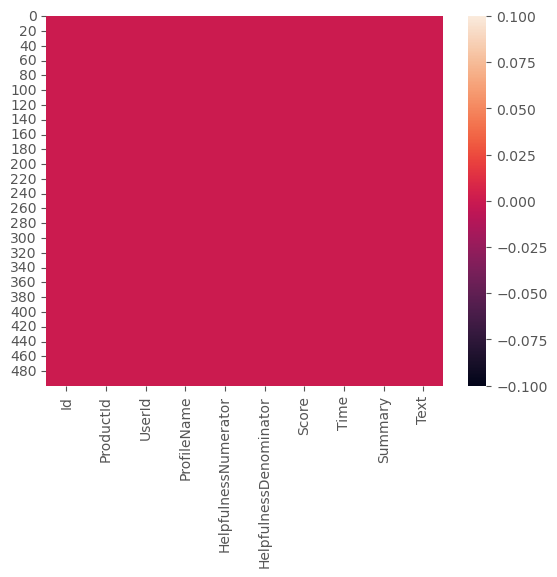

In [5]:
null_val_cols = df.isna().sum()
null_val_cols.to_csv('sum_of_nulls_in_columns.csv', encoding='utf-8', index=False)
null_val_cols
sns.heatmap(df.isna())

In [6]:
col_with_nan = df.columns[df.isna().any()].tolist()

for c in col_with_nan:
    df[c] = df[c].fillna('No item specified')

df.to_csv('customer_reviews_cleaned.csv')

# Removing Duplicate Data

In [7]:
def remove_duplication(data_f):
    if len(data_f[data_f.duplicated()]) != 0:
        data_f.drop_duplicates(inplace=True)
    return data_f


df = remove_duplication(data_f=df)

## Quick EDA

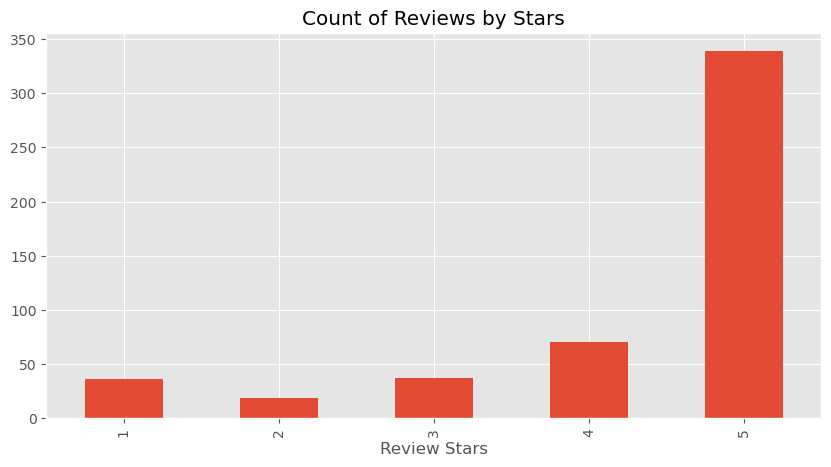

In [8]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [9]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [10]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [11]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [12]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score. Scores range between -1 to 1.

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [14]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [15]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [16]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

# Run the polarity score on the entire dataset

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

# Sentiment score and metadata

In [19]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

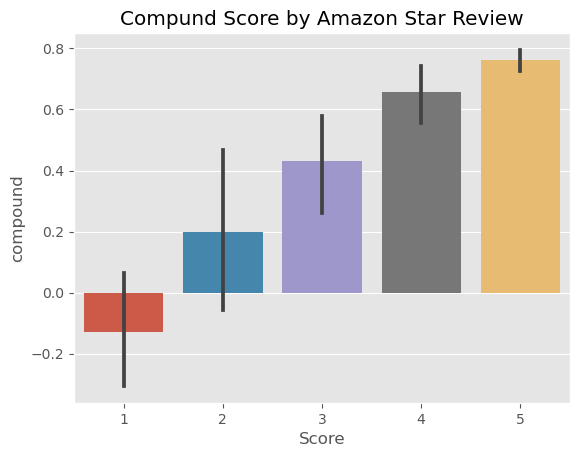

In [20]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

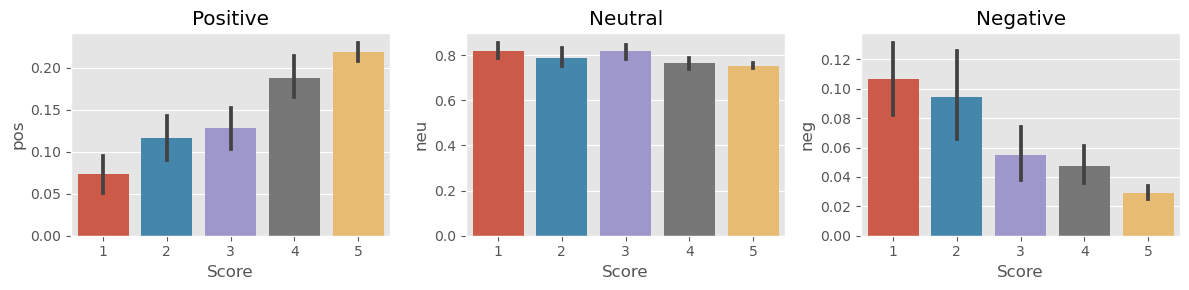

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [24]:
# results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

# Run for Roberta Model

In [25]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9763551, 'roberta_neu': 0.020687457, 'roberta_pos': 0.0029573701}


In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [27]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [28]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [29]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Combine and compare

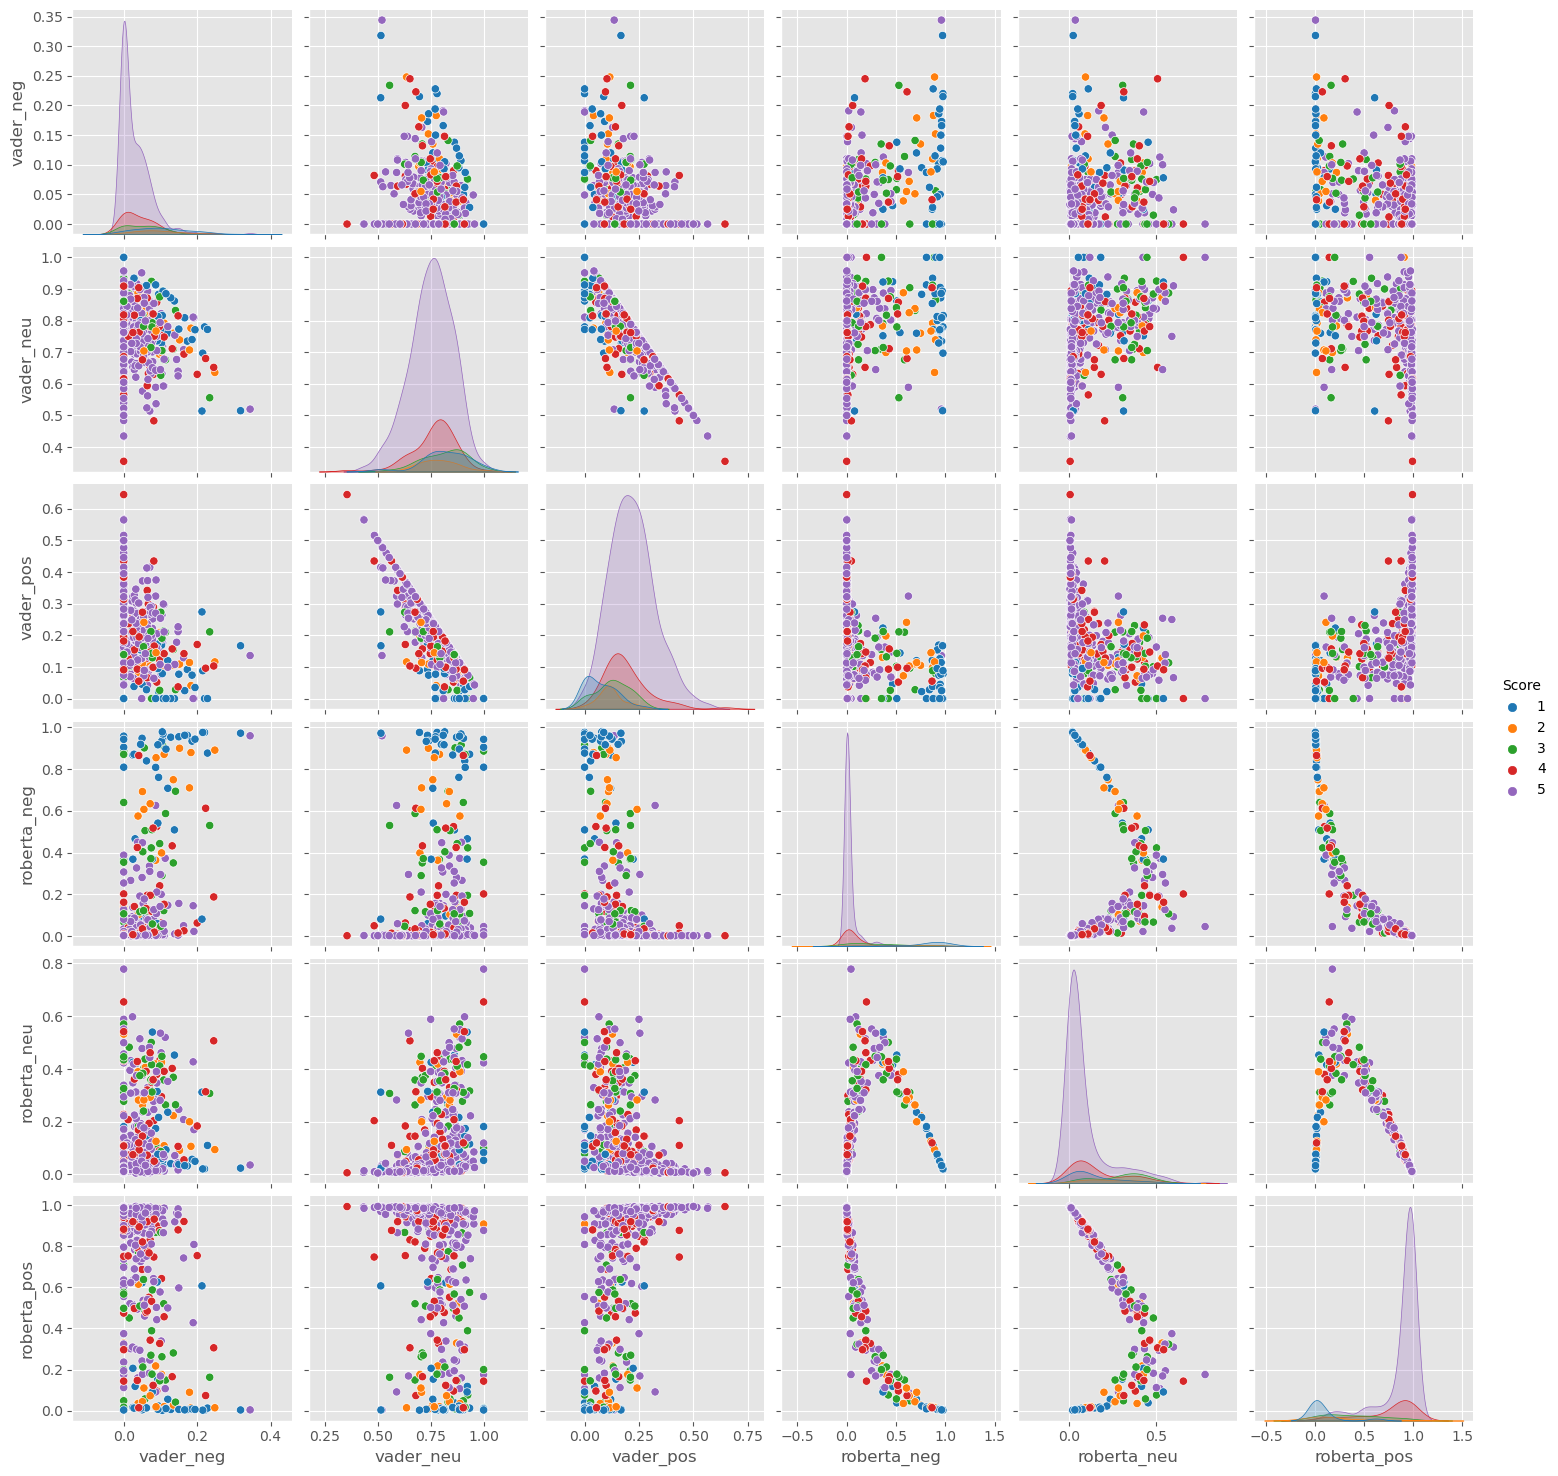

In [30]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [31]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [32]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

# nevative sentiment 5-Star view

In [33]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [34]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [81]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

sent_pipeline = pipeline("sentiment-analysis")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [76]:
sent_pipeline('I hate Rathinam College!')

[{'label': 'NEGATIVE', 'score': 0.9983023405075073}]

In [74]:
sent_pipeline('Keep it up!')

[{'label': 'POSITIVE', 'score': 0.9998477697372437}]

In [38]:
sent_pipeline('Bad product!')

[{'label': 'NEGATIVE', 'score': 0.9997724890708923}]

In [59]:
def predict_sentiment(customer_reviews_cleaned):
    result = pipeline(customer_reviews_cleaned)[0]
    label = result['label']
    score = result['score']
    if label == 'LABEL_0':
        sentiment = 'negative'
    elif label == 'LABEL_1':
        sentiment = 'positive'
    else:
        sentiment = 'neutral'
    return sentiment, score


# Exploratory Data Analysis

In [39]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,500.000000,500.000000,500.00000,500.000000,5.000000e+02
mean,250.500000,0.952000,1.27600,4.316000,1.294820e+09
std,144.481833,2.045988,2.48922,1.202929,5.072437e+07
min,1.000000,0.000000,0.00000,1.000000,1.107821e+09
25%,125.750000,0.000000,0.00000,4.000000,1.267790e+09
50%,250.500000,0.000000,0.00000,5.000000,1.312978e+09
75%,375.250000,1.000000,2.00000,5.000000,1.334621e+09
max,500.000000,19.000000,19.00000,5.000000,1.351210e+09


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    int64 
 1   ProductId               500 non-null    object
 2   UserId                  500 non-null    object
 3   ProfileName             500 non-null    object
 4   HelpfulnessNumerator    500 non-null    int64 
 5   HelpfulnessDenominator  500 non-null    int64 
 6   Score                   500 non-null    int64 
 7   Time                    500 non-null    int64 
 8   Summary                 500 non-null    object
 9   Text                    500 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.2+ KB


# Based on the information above:

- we have no null values to worry about, so no missing values
- we have two type of columns, either int64 or object, in other word strings.
- we will focus on the score, summary and text column so we can drop the rest

In [41]:
all_cols = df.columns
keep_cols = ['Score', 'Summary', 'Text']
df.drop([c for c in all_cols if c not in keep_cols], axis=1, inplace=True)
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


# Score Distribution Before Aggregation

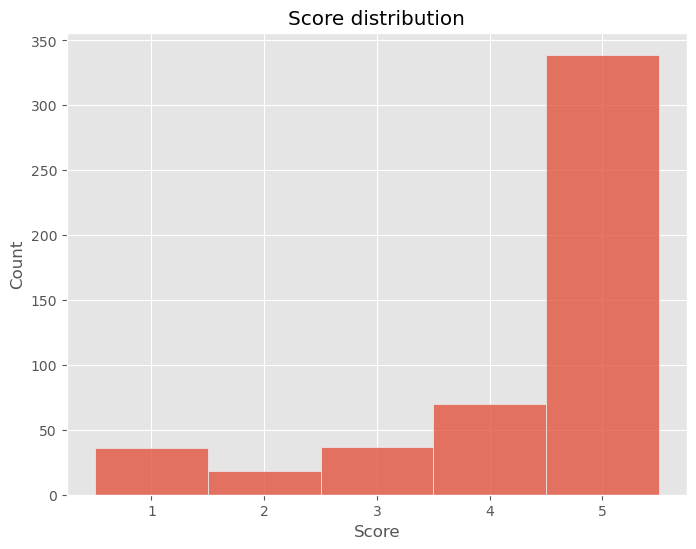

In [42]:
plt.figure(figsize=(8,6))
plt.title('Score distribution')
sns.histplot(df['Score'], discrete=True);

# Creating a new column ‘sentiment’ based on ‘Score’

In [43]:
def sentiments(df):
    return 'Positive' if (df['Score'] > 3) else 'Negative'
df['sentiment'] = df.apply(sentiments, axis=1)
df.head()

,Score,Summary,Text,sentiment
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,2,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [44]:
df.drop(['Score'], axis=1, inplace=True)

# Plot Score after Aggregation

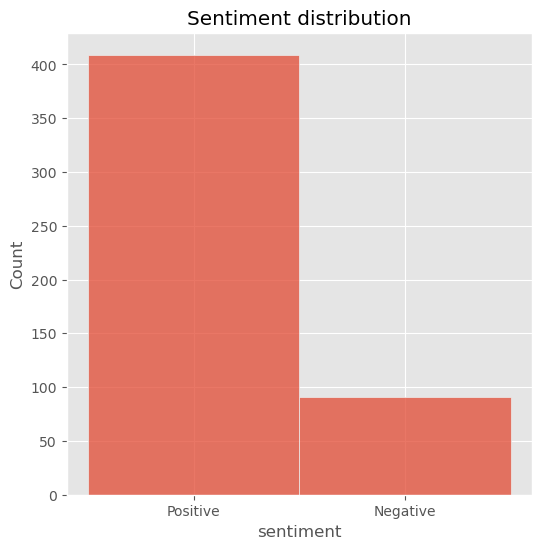

In [45]:
plt.figure(figsize=(6,6))
plt.title('Sentiment distribution')
sns.histplot(df['sentiment']);

- We can see that the data is highly imbalanced toward positive reviews so we need to be careful when splitting the dataset into training and testing datasets.

# Combine columns Summary with Text into full_text

In [46]:
df['full_text'] = df['Summary'] + '. ' + df['Text']
df.head()

,Summary,Text,sentiment,full_text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,Good Quality Dog Food. I have bought several o...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,Not as Advertised. Product arrived labeled as ...
2,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,"""Delight"" says it all. This is a confection th..."
3,Cough Medicine,If you are looking for the secret ingredient i...,Negative,Cough Medicine. If you are looking for the sec...
4,Great taffy,Great taffy at a great price. There was a wid...,Positive,Great taffy. Great taffy at a great price. Th...


In [47]:
df.drop(['Summary', 'Text'], axis=1, inplace=True)

# Clean the text
- Data cleaning involves deleting special letters, digits, irrelevant symbols, and stop words. It is also necessary to translate the terms to their root form for easier interpretation.

In [48]:
def replace_contractions(s):
    #dictionary consisting of the contraction and the actual value
    Apos_dict={"'s":" is","n't":" not","'m":" am","'ll":" will",
               "'d":" would","'ve":" have","'re":" are"}

    #replace the contractions
    for key,value in Apos_dict.items():
        if key in s:
            s=s.replace(key,value)
    return s

In [49]:
def remove_punctuation(s, punct_list):
    for punc in punct_list:
        if punc in s:
            s = s.replace(punc, ' ')
    return s.strip()

In [50]:
def truncate_large_review(s, seq_length):
    ''' Return a truncated s to the input seq_length.
    '''    
    review_len = len(s)
        
    if review_len > seq_length:
        return s[0:seq_length]
    return s

In [51]:
def cleaning(df):
    # make text lowercase
    df['full_text'] = df['full_text'].apply(lambda s: str(s).lower())
    print('To lowercase is done')
    
    # replace contractions
    df['full_text'] = df['full_text'].apply(lambda s: replace_contractions(s))
    print('Contractions replacement is done')
    
    # remove html tags
    df['full_text'] = df['full_text'].apply(lambda s: re.compile(r'<[^>]+>').sub('', s))
    print('HTML tags removal is done')
    
    # remove punctuation
    regular_punct = list(string.punctuation)
    df['full_text'] = df['full_text'].apply(lambda s: remove_punctuation(s, regular_punct))
    print('Punctuation removal is done')
    
    # split attached words
    df['full_text'] = df['full_text'].apply(lambda s: " ".join([x for x in re.split("([A-Z][a-z]+[^A-Z]*)",s) if x]))
    print('Splitting attached words is done')
    
    # Replacing the digits/numbers
    df['full_text'] = df['full_text'].apply(lambda s: re.sub(r'\d+', '', s))
    print('Numbers replacement is done')
    
    # truncate large review
    df['full_text'] = df['full_text'].apply(lambda s: truncate_large_review(s, 300))
    print('Truncation of large reviews is done')

    return df

df = cleaning(df)

To lowercase is done
Contractions replacement is done
HTML tags removal is done
Punctuation removal is done
Splitting attached words is done
Numbers replacement is done
Truncation of large reviews is done


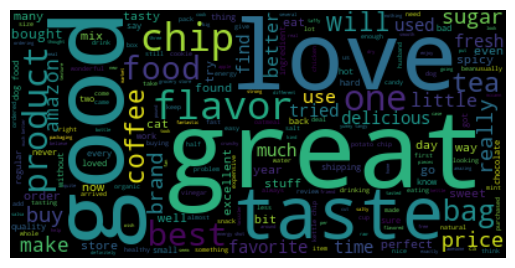

In [52]:
common_words=''
for i in df.full_text:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show() 

In [53]:
df.head()

,sentiment,full_text
0,Positive,good quality dog food i have bought several o...
1,Negative,not as advertised product arrived labeled as ...
2,Positive,delight says it all this is a confection tha...
3,Negative,cough medicine if you are looking for the sec...
4,Positive,great taffy great taffy at a great price th...


# Deductions From Data Exploration
- we can see in the word cloud that most reviews are positive since one of the biggest word is love, and we see words like good, great, delicious, etc. 
- We can also see that the dataset is related to food since we see words like taste, coffee, eat, etc.

# Querrying Structured Data using NLTK

In [54]:
tqa = pipeline(task="table-question-answering", 
               model="google/tapas-base-finetuned-wtq")

In [55]:
table = pd.read_csv('Data.csv')
table = table.astype(str)

In [ ]:
table

In [57]:
query = "what is the name of the restaurant with highest negative review?"
print(tqa(table=table, query=query)["answer"])

/Users/iprincetech/opt/anaconda3/lib/python3.9/site-packages/transformers/models/tapas/modeling_tapas.py:1788: UserWarning: scatter_reduce() is in beta and the API may change at any time. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1615.)
  segment_means = out.scatter_reduce(


Jacques Restaurant


In [58]:
query = ["Span of vishnu tea shop?"]
         
print(tqa(table=table, query=query)["answer"])

1991-2016


# The End